In [1]:
# 1. Importar librerías y cargar datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Cargar datos
df = pd.read_csv("../data_sintetica/clientes_tienda_virtual.csv")

# Filtrar solo compradores
df = df[df['total_compra'] > 0].copy()

In [2]:
# 2. Preparar features y target
X = df[['grupo_edad', 'region', 'nivel_ingresos', 'horas_conectado', 'clics_en_productos', 'uso_cupones']]
y = df['total_compra']

cat_cols = ['grupo_edad', 'region', 'nivel_ingresos']
num_cols = ['horas_conectado', 'clics_en_productos', 'uso_cupones']

In [3]:
# 3. Construir pipeline con OneHotEncoder y regresión lineal
# Preprocesamiento
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), cat_cols)
], remainder='passthrough')

# Pipeline de regresión
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regression', LinearRegression())
])

In [4]:
# 4. División de datos y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [5]:
# 5. Predicción y evaluación
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 373.30
R²: 0.23


In [6]:
# 6. Validación cruzada

# Definimos el scorer para MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Diccionario de métricas
scoring = {
    'r2': 'r2',
    'mse': mse_scorer
}

# Validación cruzada
results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)

r2_scores = results['test_r2']
mse_scores = -results['test_mse'] 
rmse_scores = np.sqrt(mse_scores)

# Mostrar resultados
print(" Validación cruzada de regresión lineal:")
print(f"R² por fold: {np.round(r2_scores, 3)}")
print(f"Promedio R² (CV): {r2_scores.mean():.2f}")
print(f"MSE por fold: {np.round(mse_scores, 2)}")
print(f"Promedio MSE: {mse_scores.mean():.2f}")
print(f"Promedio RMSE: {rmse_scores.mean():.2f}")


 Validación cruzada de regresión lineal:
R² por fold: [0.26  0.243 0.219 0.218 0.251]
Promedio R² (CV): 0.24
MSE por fold: [136634.43 137440.37 145122.89 143451.07 144210.71]
Promedio MSE: 141371.89
Promedio RMSE: 375.96


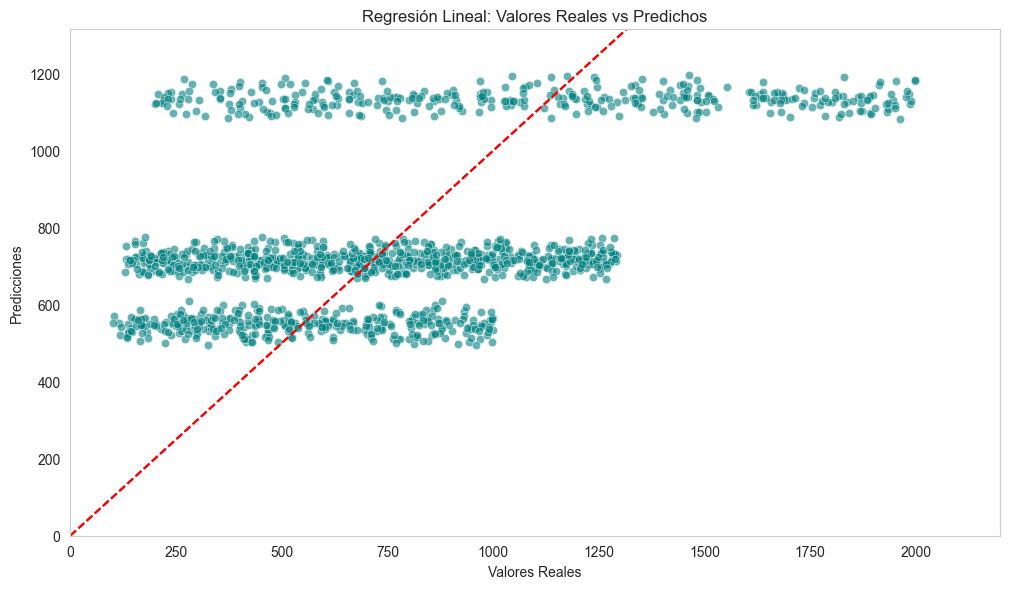

In [8]:
# 7. Gráfico de dispersión con línea de referencia
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
sns.lineplot(x=[0, max(y_test)], y=[0, max(y_test)], color='red', linestyle='--')
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.xlim(0, max(y_test) * 1.1)
plt.ylim(0, max(y_pred) * 1.1)
plt.title("Regresión Lineal: Valores Reales vs Predichos")
plt.tight_layout()
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.grid()
plt.show()

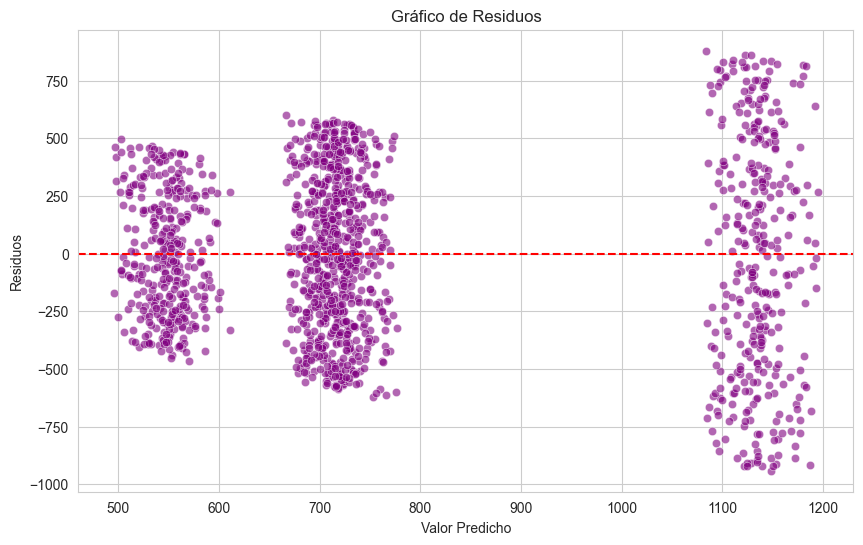

In [9]:
# 8. Gráfico de residuos
residuos = y_test - y_pred  
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuos, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valor Predicho")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.show()

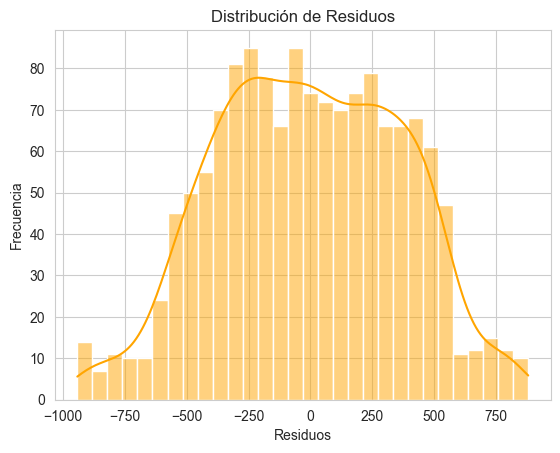

In [10]:
# 9. Gráfico de distribución de residuos
sns.histplot(residuos, bins=30, kde=True, color='orange')
plt.title("Distribución de Residuos")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_16232\319664387.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_df, x='Importancia', y='Característica', palette='viridis')


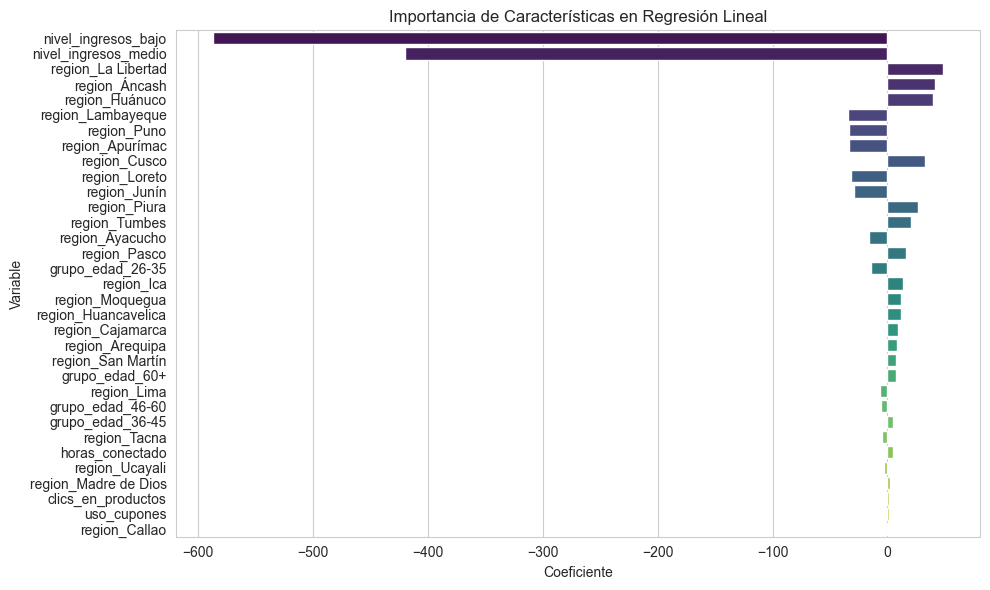

In [11]:
# 10. Importancia de características
# Obtener coeficientes del modelo lineal dentro del pipeline
importances = pipeline.named_steps['regression'].coef_
 
# Obtener nombres de columnas transformadas por OneHotEncoder
encoder = pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_features = encoder.get_feature_names_out(cat_cols)

# Concatenar nombres de variables: categóricas codificadas + numéricas
feature_names = np.concatenate([encoded_cat_features, num_cols])

# Crear DataFrame para ordenar e interpretar mejor
importancia_df = pd.DataFrame({
    'Característica': feature_names,
    'Importancia': importances
}).sort_values(by='Importancia', key=abs, ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_df, x='Importancia', y='Característica', palette='viridis')
plt.title("Importancia de Características en Regresión Lineal")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

In [12]:
# 11. Guardar predicciones
resultados = pd.DataFrame({'real': y_test, 'predicho': y_pred})
resultados.to_csv(os.path.join("..", "resultados_modelos", "regresion", "predicciones_regresion_lineal.csv"), index=False)

# 12. Guardar test  
X_test.to_csv(os.path.join("..", "resultados_modelos", "regresion", "X_test_rl.csv"), index=False)
y_test.to_csv(os.path.join("..", "resultados_modelos", "regresion", "y_test_rl.csv"), index=False)